# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from matplotlib.pylab import rcParams
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
motorbike_df = pd.read_csv("motorbike_ambulance_calls.csv")
print(motorbike_df.head()) 

   index    date  season  yr  mnth  hr  holiday  weekday  workingday  \
0      1  1/1/11  spring   0     1   0        0        6           0   
1      2  1/1/11  spring   0     1   1        0        6           0   
2      3  1/1/11  spring   0     1   2        0        6           0   
3      4  1/1/11  spring   0     1   3        0        6           0   
4      5  1/1/11  spring   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  cnt  
0           1  0.24  0.2879  0.81        0.0   16  
1           1  0.22  0.2727  0.80        0.0   40  
2           1  0.22  0.2727  0.80        0.0   32  
3           1  0.24  0.2879  0.75        0.0   13  
4           1  0.24  0.2879  0.75        0.0    1  


In [23]:
print(f"Shape of the DataFrame: {motorbike_df.shape}")
missing_values = motorbike_df.isna().sum()
print("Missing values in each column:")
print(missing_values)

Shape of the DataFrame: (17379, 15)
Missing values in each column:
index         0
date          0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64


In [24]:
without_duplicates_df = motorbike_df.drop_duplicates()
print(without_duplicates_df.head())

   index    date  season  yr  mnth  hr  holiday  weekday  workingday  \
0      1  1/1/11  spring   0     1   0        0        6           0   
1      2  1/1/11  spring   0     1   1        0        6           0   
2      3  1/1/11  spring   0     1   2        0        6           0   
3      4  1/1/11  spring   0     1   3        0        6           0   
4      5  1/1/11  spring   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  cnt  
0           1  0.24  0.2879  0.81        0.0   16  
1           1  0.22  0.2727  0.80        0.0   40  
2           1  0.22  0.2727  0.80        0.0   32  
3           1  0.24  0.2879  0.75        0.0   13  
4           1  0.24  0.2879  0.75        0.0    1  


In [25]:
descriptive_stats = motorbike_df.describe()
print(descriptive_stats)

            index            yr          mnth            hr       holiday  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      0.502561      6.537775     11.546752      0.028770   
std     5017.0295      0.500008      3.438776      6.914405      0.167165   
min        1.0000      0.000000      1.000000      0.000000      0.000000   
25%     4345.5000      0.000000      4.000000      6.000000      0.000000   
50%     8690.0000      1.000000      7.000000     12.000000      0.000000   
75%    13034.5000      1.000000     10.000000     18.000000      0.000000   
max    17379.0000      1.000000     12.000000     23.000000      1.000000   

            weekday    workingday    weathersit          temp         atemp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       3.003683      0.682721      1.425283      0.496987      0.475775   
std        2.005771      0.465431      0.639357      0.192556      0.

In [26]:
unique_seasons = motorbike_df['season'].unique()
print(f"Unique values in the 'season' column: {unique_seasons}")

Unique values in the 'season' column: ['spring' 'summer' 'autumn' 'winter']



Фічу season слід перевести з текстового формату (string) у категоріальну числову ознаку (numerical feature).
Окрім цього, потрібно конвертувати значення в колонці date у формат datetime.








In [27]:
motorbike_df["date"] = pd.to_datetime(motorbike_df["date"])
print(motorbike_df["date"].head())

0   2011-01-01
1   2011-01-01
2   2011-01-01
3   2011-01-01
4   2011-01-01
Name: date, dtype: datetime64[ns]


C:\Users\Микола\AppData\Local\Temp\ipykernel_13520\209761712.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  motorbike_df["date"] = pd.to_datetime(motorbike_df["date"])


In [28]:
motorbike_df["season"] = motorbike_df["date"].dt.month.map(lambda month: (month % 12) // 3)
print(motorbike_df.head())

   index       date  season  yr  mnth  hr  holiday  weekday  workingday  \
0      1 2011-01-01       0   0     1   0        0        6           0   
1      2 2011-01-01       0   0     1   1        0        6           0   
2      3 2011-01-01       0   0     1   2        0        6           0   
3      4 2011-01-01       0   0     1   3        0        6           0   
4      5 2011-01-01       0   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  cnt  
0           1  0.24  0.2879  0.81        0.0   16  
1           1  0.22  0.2727  0.80        0.0   40  
2           1  0.22  0.2727  0.80        0.0   32  
3           1  0.24  0.2879  0.75        0.0   13  
4           1  0.24  0.2879  0.75        0.0    1  


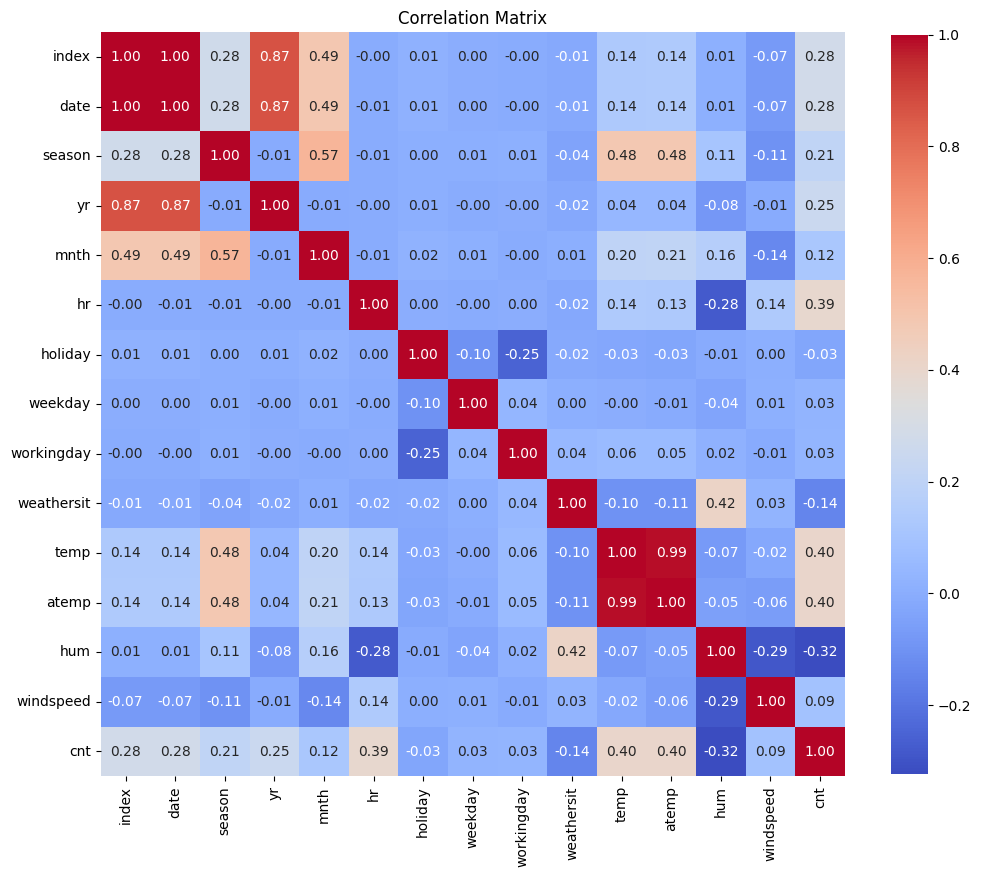

In [34]:
correlation_matrix = motorbike_df.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix')
plt.show()

Колонки temp і atemp мають високу кореляцію, тому одну з них можна вилучити. Найдоцільніше видалити колонку atemp, оскільки вона відображає суб'єктивну температуру, що базується на відчуттях людей, а не реальні вимірювання.

In [35]:
motorbike_df = motorbike_df.drop(columns=["atemp"])
print(motorbike_df.head())

   index       date  season  yr  mnth  hr  holiday  weekday  workingday  \
0      1 2011-01-01       0   0     1   0        0        6           0   
1      2 2011-01-01       0   0     1   1        0        6           0   
2      3 2011-01-01       0   0     1   2        0        6           0   
3      4 2011-01-01       0   0     1   3        0        6           0   
4      5 2011-01-01       0   0     1   4        0        6           0   

   weathersit  temp   hum  windspeed  cnt  
0           1  0.24  0.81        0.0   16  
1           1  0.22  0.80        0.0   40  
2           1  0.22  0.80        0.0   32  
3           1  0.24  0.75        0.0   13  
4           1  0.24  0.75        0.0    1  


C:\Users\Микола\AppData\Local\Temp\ipykernel_13520\2124147052.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=motorbike_df, x=col, ax=subplot, alpha=0.6, palette='bright')
C:\Users\Микола\AppData\Local\Temp\ipykernel_13520\2124147052.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=motorbike_df, x=col, ax=subplot, alpha=0.6, palette='bright')
C:\Users\Микола\AppData\Local\Temp\ipykernel_13520\2124147052.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=motorbike_df, x=col, ax=subplot, alpha=0.6, palette='bright'

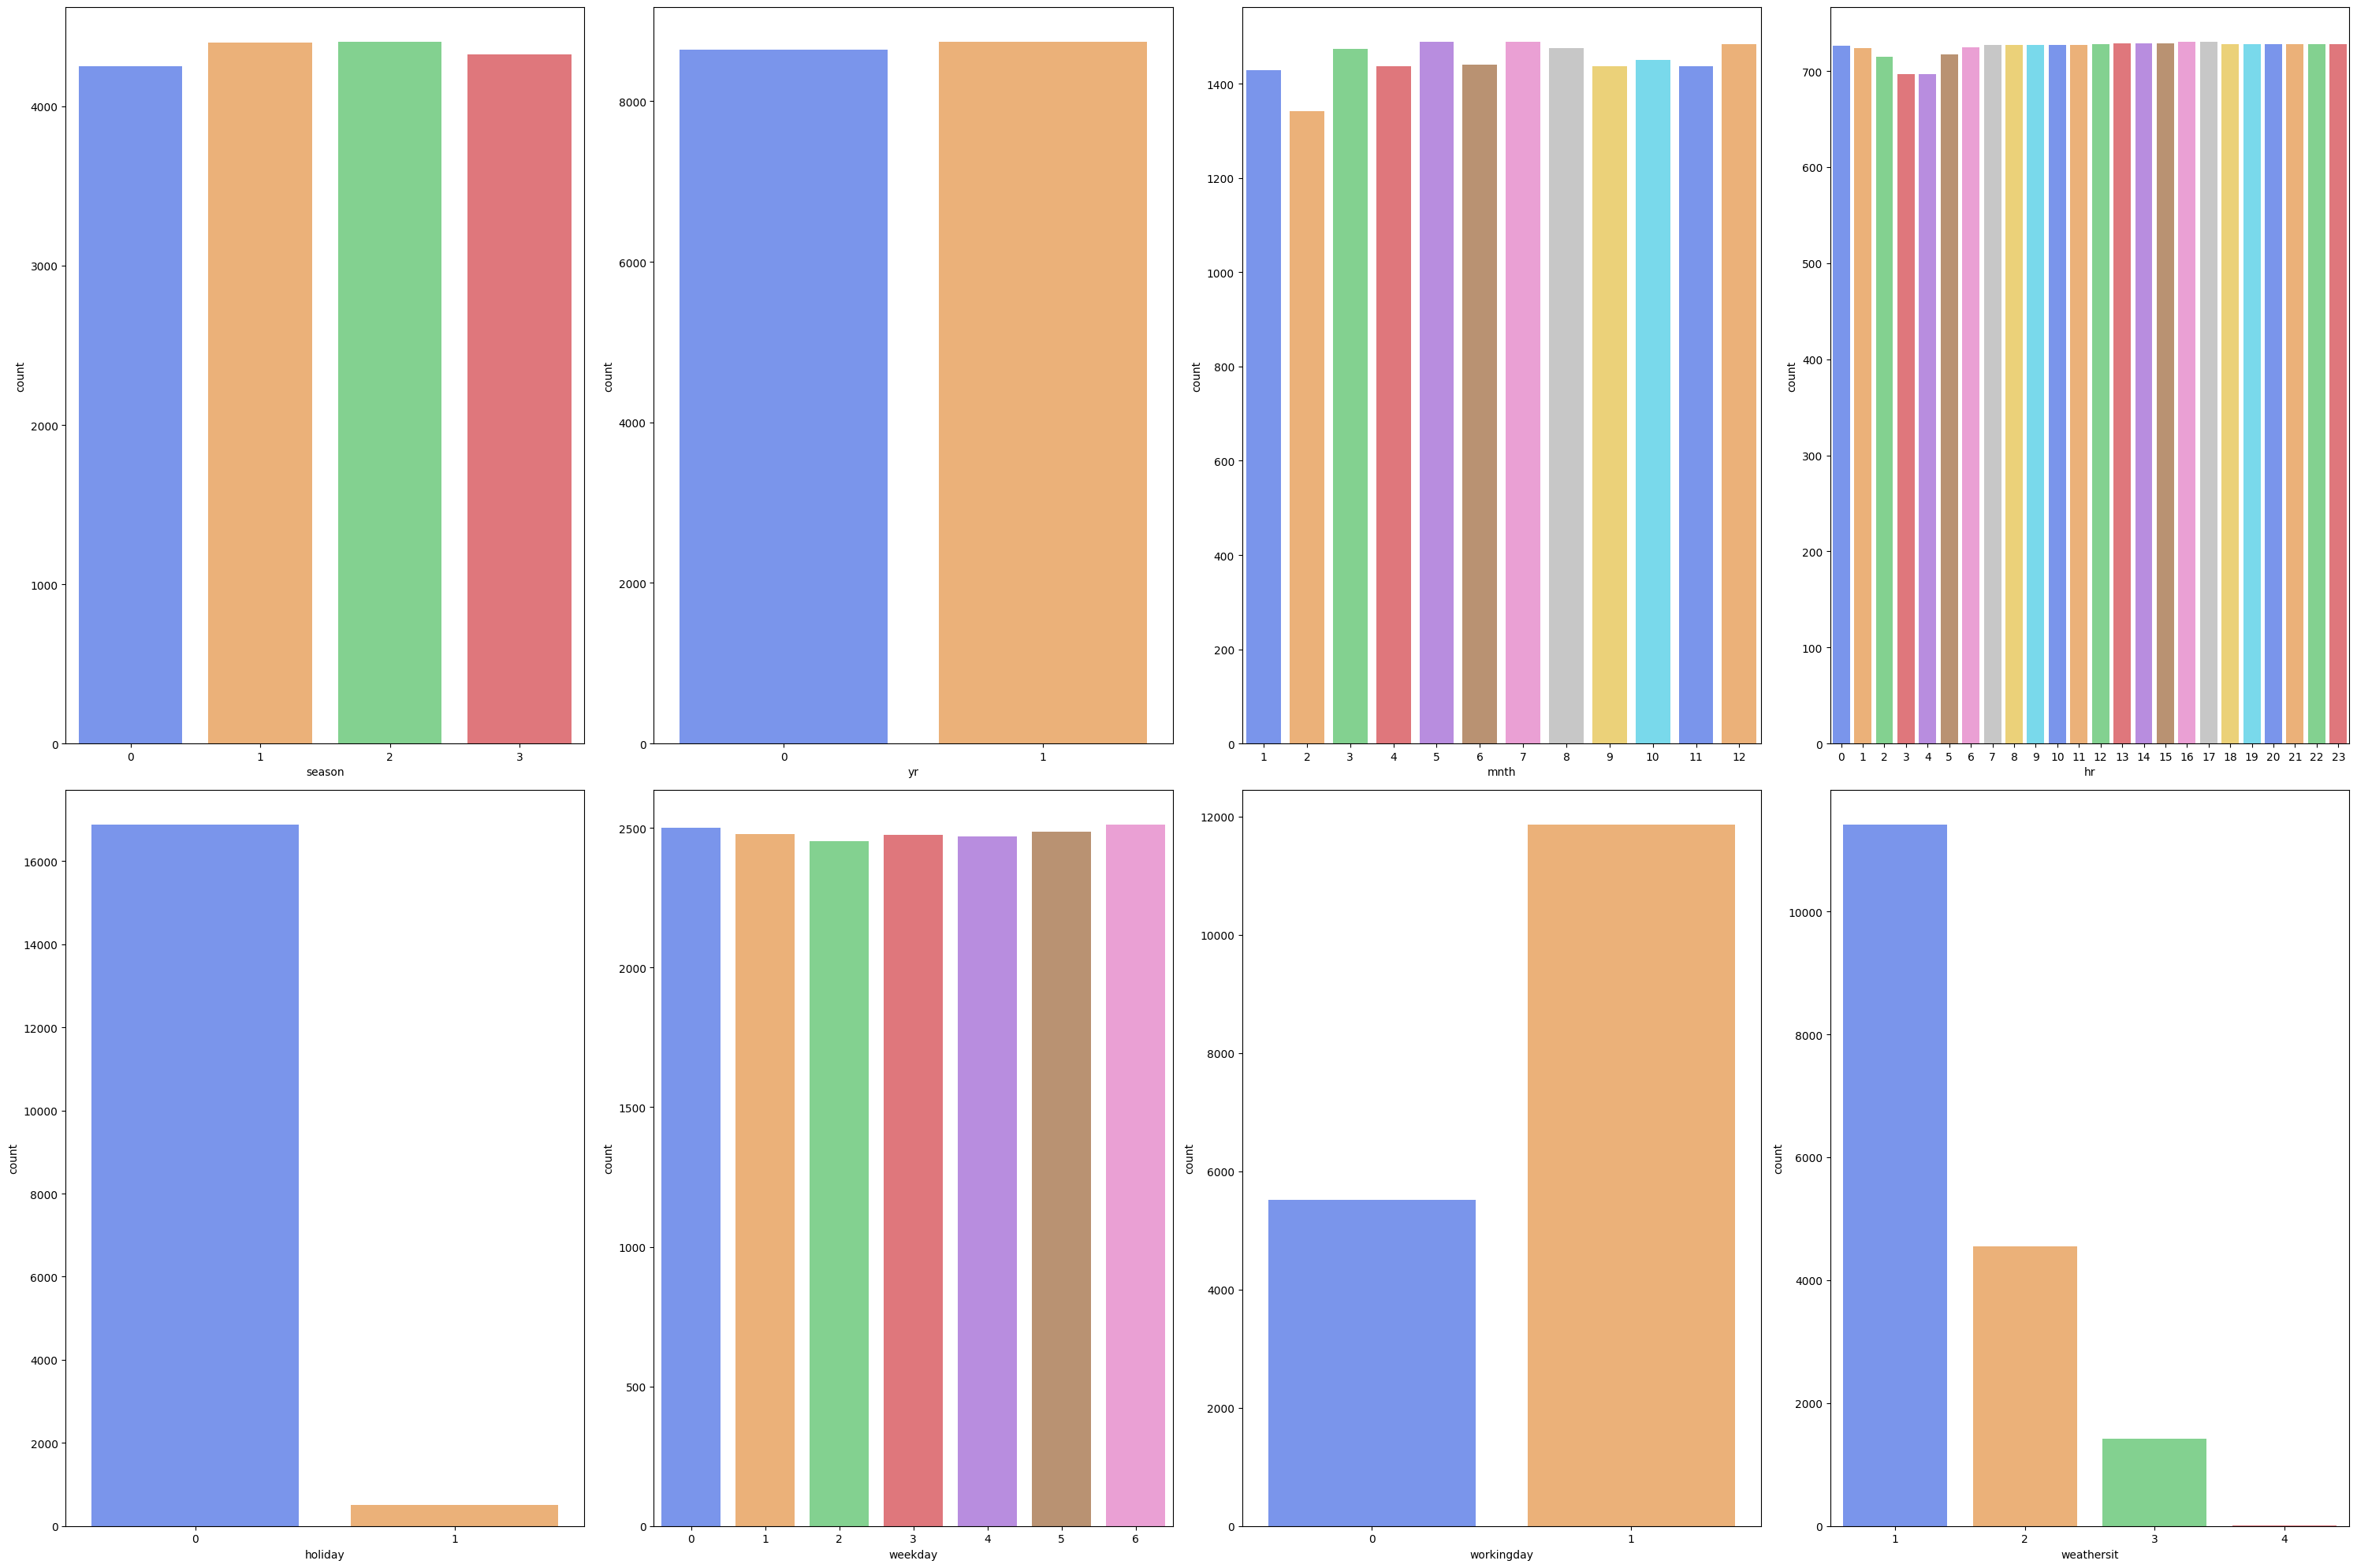

In [41]:
categorical_columns = motorbike_df.select_dtypes(include='int').columns[1:-1]
fig, ax = plt.subplots(2, 4, figsize=(30, 20))
for col, subplot in zip(categorical_columns, ax.flatten()):
    sns.countplot(data=motorbike_df, x=col, ax=subplot, alpha=0.6, palette='bright')
plt.tight_layout()
plt.show()

In [43]:
numerical_columns = ['temp', 'hum', 'windspeed', 'cnt']
count_sigmas = 3

statistics = []
for col in numerical_columns:
    mean = motorbike_df[col].mean()
    std = motorbike_df[col].std()
    lower_bound = mean - count_sigmas * std
    upper_bound = mean + count_sigmas * std
    outliers_count = motorbike_df[(motorbike_df[col] < lower_bound) | (motorbike_df[col] > upper_bound)].shape[0]
    
    statistics.append({
        "Feature": col,
        "Mean": mean,
        "Std": std,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound,
        "Outliers Count": outliers_count
    })

sigma_df = pd.DataFrame(statistics)

print(sigma_df)

     Feature        Mean         Std  Lower Bound  Upper Bound  Outliers Count
0       temp    0.496987    0.192556    -0.080681     1.074656               0
1        hum    0.627229    0.192930     0.048439     1.206018              22
2  windspeed    0.190098    0.122340    -0.176923     0.557118             107
3        cnt  189.463088  181.387599  -354.699710   733.625885             244


In [44]:
percentiles = []
for col in numerical_columns:
    percentiles.append({
        "Feature": col,
        "25th Percentile": motorbike_df[col].quantile(0.25),
        "50th Percentile (Median)": motorbike_df[col].quantile(0.50),
        "75th Percentile": motorbike_df[col].quantile(0.75)
    })

percentiles_df = pd.DataFrame(percentiles)

percentiles_df.iloc[:, 1:] = percentiles_df.iloc[:, 1:].round(4)

print(percentiles_df)

     Feature  25th Percentile  50th Percentile (Median)  75th Percentile
0       temp           0.3400                     0.500           0.6600
1        hum           0.4800                     0.630           0.7800
2  windspeed           0.1045                     0.194           0.2537
3        cnt          40.0000                   142.000         281.0000


Слід звернути увагу на 75-й перцентиль, оскільки тут можуть бути аномалії. Наприклад, показники вологості 78%, 25%, та кількість викликів швидкої 281 виглядають підозріло. Це дає підстави припустити, що в цих даних можна виявити аномалії.








In [45]:
data_by_year = motorbike_df.groupby('yr').agg(
    Count=('cnt', 'count'),
    Mean_Count=('cnt', 'mean'),
    Std_Count=('cnt', 'std'),
    Min_Count=('cnt', 'min'),
    Max_Count=('cnt', 'max')
).reset_index()

data_by_year.rename(columns={'yr': 'Year'}, inplace=True)

print(data_by_year)

   Year  Count  Mean_Count   Std_Count  Min_Count  Max_Count
0     0   8645  143.794448  133.797854          1        651
1     1   8734  234.666361  208.910941          1        977


In [46]:
pt = PowerTransformer(method='box-cox', standardize=True)
motorbike_df['cnt_transformed'] = pt.fit_transform(motorbike_df[['cnt']])

X = motorbike_df[[col for col in motorbike_df.columns if col not in ['date', 'cnt', 'cnt_transformed', 'year']]]
y = motorbike_df['cnt_transformed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=50, max_depth=3)
xgb_model.fit(X_train, y_train)

feature_importance = xgb_model.feature_importances_

feature_importance_matrix = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance_matrix)

       Feature  Importance
4           hr    0.439660
9         temp    0.139389
8   weathersit    0.122768
0        index    0.113601
7   workingday    0.109932
10         hum    0.032942
6      weekday    0.017724
5      holiday    0.010198
11   windspeed    0.008124
3         mnth    0.005662
1       season    0.000000
2           yr    0.000000


Отже, аналізуючи матрицю важливостей, можна зробити висновок, що найважливішими ознаками є година та температура. Виходячи з цього, наступні кроки будуть такі:

1. Нормалізація даних: Застосуємо метод Box-Cox, але спочатку виконаємо зсув даних, оскільки Box-Cox працює лише з позитивними значеннями.
2. Пошук аномалій: Використаємо методи IsolationForest, LOF та XGBoost для виявлення аномальних значень у даних.

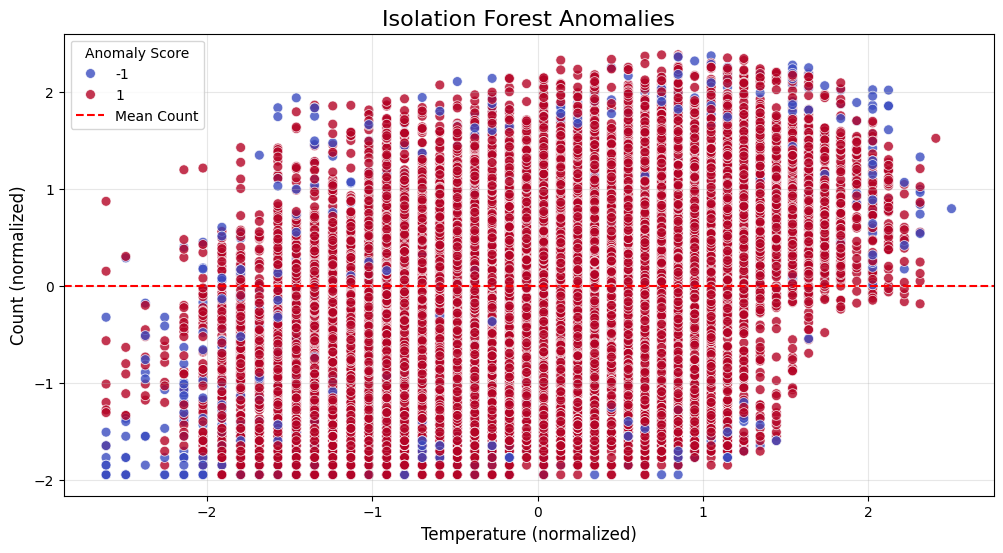

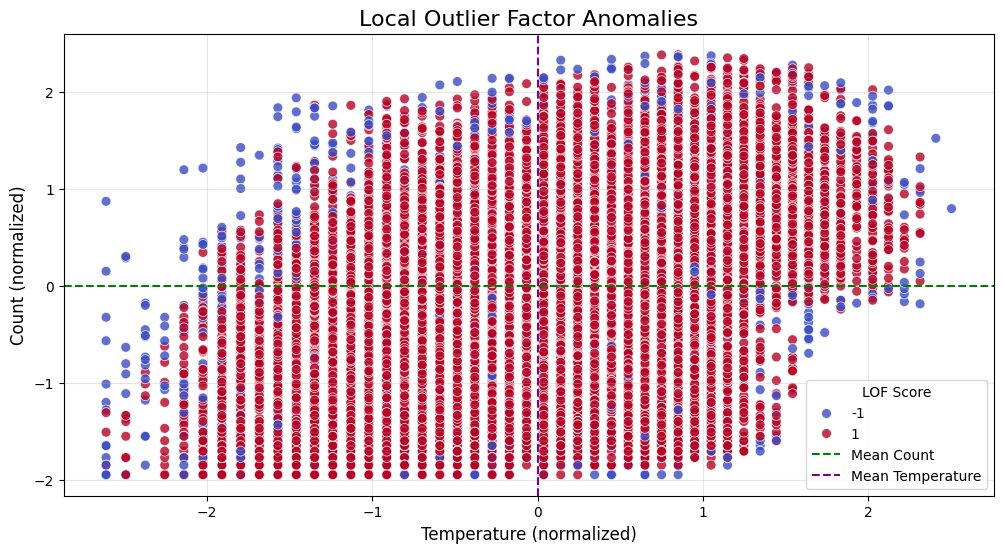

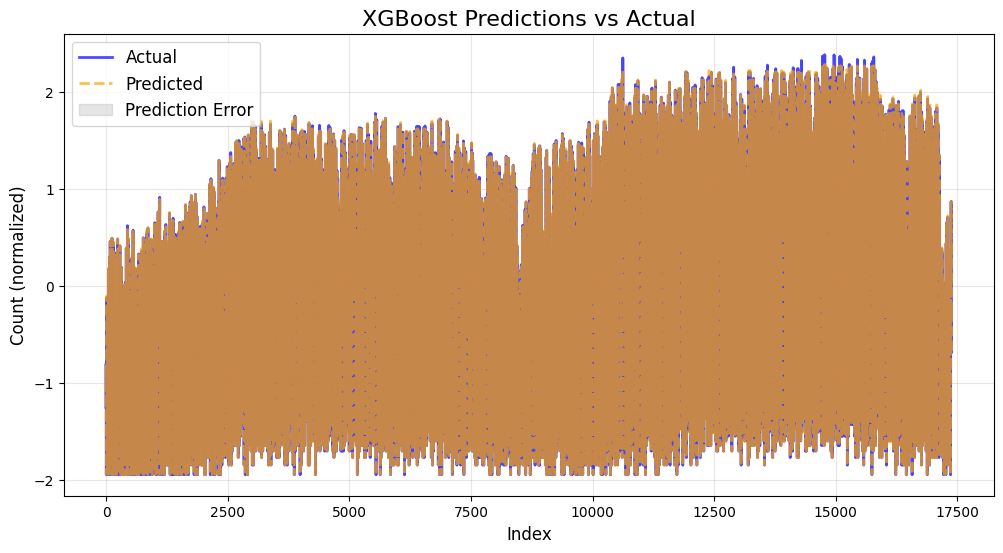

In [51]:
plt.figure(figsize=(12, 6))
plt.title("Isolation Forest Anomalies", fontsize=16)
sns.scatterplot(data=motorbike_df, x='temp', y='cnt', hue='isolation_forest_score', palette='coolwarm', s=50, alpha=0.8)
plt.axhline(y=motorbike_df['cnt'].mean(), color='red', linestyle='--', label='Mean Count')
plt.xlabel('Temperature (normalized)', fontsize=12)
plt.ylabel('Count (normalized)', fontsize=12)
plt.legend(title='Anomaly Score', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
plt.title("Local Outlier Factor Anomalies", fontsize=16)
sns.scatterplot(data=motorbike_df, x='temp', y='cnt', hue='lof_score', palette='coolwarm', s=50, alpha=0.8)
plt.axhline(y=motorbike_df['cnt'].mean(), color='green', linestyle='--', label='Mean Count')
plt.axvline(x=motorbike_df['temp'].mean(), color='purple', linestyle='--', label='Mean Temperature')
plt.xlabel('Temperature (normalized)', fontsize=12)
plt.ylabel('Count (normalized)', fontsize=12)
plt.legend(title='LOF Score', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
plt.title("XGBoost Predictions vs Actual", fontsize=16)
plt.plot(motorbike_df['cnt'], label='Actual', alpha=0.7, color='blue', linewidth=2, linestyle='-')
plt.plot(motorbike_df['xgboost_pred'], label='Predicted', alpha=0.7, color='orange', linewidth=2, linestyle='--')
plt.fill_between(range(len(motorbike_df)), motorbike_df['cnt'], motorbike_df['xgboost_pred'], color='gray', alpha=0.2, label='Prediction Error')
plt.legend(fontsize=12)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Count (normalized)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()